# 1. Importing the libraries

In [1]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction import DictVectorizer

import pandas as pd
import numpy as np
import xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

import nltk

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

import matplotlib.pyplot as plt 
import re #re allows you to manipulate strings with regrex style manipulation
import string 

import spacy 
from sklearn.base import BaseEstimator, TransformerMixin


# 2. Dataset preparation

## 2.1 Importing the dataset

In [2]:
data2 = pd.read_excel('update2_covid_19_data.xls')
covid_data = data2[["LABEL", "MESSAGE"]]
covid_data.shape
#covid_data.head()

#X = covid_data["MESSAGE"]
#label = covid_data["LABEL"]


(303, 2)

## 2.2 Text Cleaning

### 2.2.1 Lemmatization

In [3]:
#https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

def lemma(x):
    sentence = " ".join(lemmatizer.lemmatize(w, get_wordnet_pos(w)) 
                        for w in nltk.word_tokenize(x))
    return sentence

#This allows you apply functions to each row in a column
round1 = lambda x: lemma(x) 

#Create a new column with the clean text data
covid_data['clean_text'] = covid_data["MESSAGE"].apply(round1)
covid_data.head()


,LABEL,MESSAGE,clean_text
0,MYTH,5G mobile networks spread COVID-19.,5G mobile network spread COVID-19 .
1,MYTH,"I can get the coronavirus from food, food pack...","I can get the coronavirus from food , food pac..."
2,MYTH,I can get COVID-19 from my mail or other packa...,I can get COVID-19 from my mail or other packa...
3,MYTH,Leaf blowers spread COVID-19.,Leaf blower spread COVID-19 .
4,MYTH,COVID-19 was circulating last summer at Green...,COVID-19 be circulate last summer at Greenspri...


### 2.2.2 Removing stop words

In [4]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, 
    remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # text = re.sub('\w*\d\w*', '', text)
    return text


#This allows you apply functions to each row in a column
round1 = lambda x: clean_text_round1(x) 

#Create a new column with the clean text data
covid_data['clean_text2'] = covid_data['clean_text'].apply(round1)
covid_data.head()


,LABEL,MESSAGE,clean_text,clean_text2
0,MYTH,5G mobile networks spread COVID-19.,5G mobile network spread COVID-19 .,5g mobile network spread covid19
1,MYTH,"I can get the coronavirus from food, food pack...","I can get the coronavirus from food , food pac...",i can get the coronavirus from food food pack...
2,MYTH,I can get COVID-19 from my mail or other packa...,I can get COVID-19 from my mail or other packa...,i can get covid19 from my mail or other packag...
3,MYTH,Leaf blowers spread COVID-19.,Leaf blower spread COVID-19 .,leaf blower spread covid19
4,MYTH,COVID-19 was circulating last summer at Green...,COVID-19 be circulate last summer at Greenspri...,covid19 be circulate last summer at greensprin...


In [5]:
# Removing stopwords including keywords like "covid19"
stop_words = set(stopwords.words('english'))

new_words = ["covid19", "virus", "coronavirus", "become", "get", "need","people"]
stop_words = stop_words.union(new_words)

def remove(x):
    sentence = " ".join(w for w in  nltk.word_tokenize(x) if not w in stop_words)
    return sentence

round2 = lambda x: remove(x) 
#Create a new column with the clean text data
covid_data['clean_stop'] = covid_data["clean_text2"].apply(round2)
covid_data.head()


,LABEL,MESSAGE,clean_text,clean_text2,clean_stop
0,MYTH,5G mobile networks spread COVID-19.,5G mobile network spread COVID-19 .,5g mobile network spread covid19,5g mobile network spread
1,MYTH,"I can get the coronavirus from food, food pack...","I can get the coronavirus from food , food pac...",i can get the coronavirus from food food pack...,food food packaging food container
2,MYTH,I can get COVID-19 from my mail or other packa...,I can get COVID-19 from my mail or other packa...,i can get covid19 from my mail or other packag...,mail package receive
3,MYTH,Leaf blowers spread COVID-19.,Leaf blower spread COVID-19 .,leaf blower spread covid19,leaf blower spread
4,MYTH,COVID-19 was circulating last summer at Green...,COVID-19 be circulate last summer at Greenspri...,covid19 be circulate last summer at greensprin...,circulate last summer greenspring assist livin...


## 2.3 Top Words

In [6]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import plotly

## 2.3.1 unigram

In [7]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(covid_data['MESSAGE'], 20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['MESSAGE' , 'count'])
df1.groupby('MESSAGE').sum()['count'].sort_values(ascending=False).iplot(
kind='bar', yTitle='Count', linecolor='black', title='Top 20 words before text cleaning')

the 238
covid 158
19 158
to 133
and 118
of 106
coronavirus 98
can 91
or 90
you 80
is 75
in 66
with 64
from 60
that 58
people 55
are 50
for 49
have 48
virus 48


In [8]:
common_words = get_top_n_words(covid_data['clean_stop'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['clean_stop' , 'count'])
df2.groupby('clean_stop').sum()['count'].sort_values(ascending=False).iplot(
kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after text cleaning')

spread 41
prevent 24
disease 22
cause 20
symptom 20
water 19
infect 19
risk 18
infection 18
use 17
cough 17
nt 17
help 15
hand 15
soap 15
person 15
new 15
high 14
evidence 14
food 13


## 2.3.2 bigram

In [9]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(covid_data['MESSAGE'], 20)
for word, freq in common_words:
    print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['MESSAGE' , 'count'])
df3.groupby('MESSAGE').sum()['count'].sort_values(ascending=False).iplot(
kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review before text cleaning')

covid 19 158
the coronavirus 38
the virus 35
you can 22
in the 22
19 is 21
can be 17
does not 16
of the 16
there is 15
if you 14
is no 14
new coronavirus 14
from the 12
the new 12
can get 11
get covid 11
of covid 10
with covid 10
need to 10


In [10]:
common_words = get_top_n_bigram(covid_data['clean_stop'], 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['clean_stop' , 'count'])
df4.groupby('clean_stop').sum()['count'].sort_values(ascending=False).iplot(
kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review after text cleaning')

cough sneeze 9
soap water 7
social distance 7
respiratory droplet 6
hand sanitizer 6
high risk 5
help prevent 5
cloth face 5
face covering 4
immune system 4
medical condition 4
wash hand 4
fever cough 4
close contact 4
age group 4
14 day 4
face mask 4
disease cause 4
hold breath 4
hot humid 4


## 2.4 Word Cloud

In [11]:
words = []
def append(comment):
  text = comment.split() #tokenise comment into list of words
  for i in text:
    words.append(i) #append to bigger word list

add_words = lambda x: append(x)
covid_data[covid_data['LABEL']=="MYTH"]['clean_stop'].apply(add_words)
rumor = words

words = []
covid_data[covid_data['LABEL']=="FACTS"]['clean_stop'].apply(add_words)
facts = words

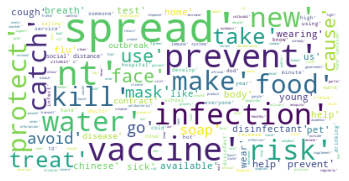

In [12]:
#Word cloud
## https://www.datacamp.com/community/tutorials/wordcloud-python
## https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

wordcloud_rumor = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=1000,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(rumor))
print(wordcloud_rumor)
wordcloud_facts = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=1000,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(facts))
print(wordcloud_facts)


plt.imshow(wordcloud_rumor)
#plt.imshow(wordcloud_facts)
plt.axis('off')
plt.show()
# fig.savefig("word1.png", dpi=900)

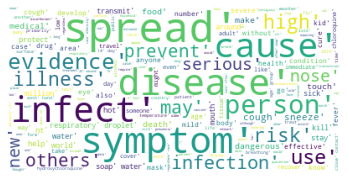

In [26]:
plt.imshow(wordcloud_facts)
plt.axis('off')
plt.show()

## 2.5 Splitting the dataset into the training set and test set

In [13]:
# Using original dataset

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(covid_data["MESSAGE"], covid_data["LABEL"],
                                                                      test_size=0.3,random_state=109)
# Encoding the label
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [96]:
# Using clean text

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(covid_data['clean_stop'], covid_data["LABEL"],
                                                                      test_size=0.3,random_state=109)
# Encoding the label
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
covid_data.head()

,LABEL,MESSAGE,RESOURCE,clean_text,clean_text2,clean_stop
0,MYTH,5G mobile networks spread COVID-19.,https://www.fairfaxcounty.gov/covid19/rumor-co...,5G mobile network spread COVID-19 .,5g mobile network spread covid19,5g mobile network spread covid19
1,MYTH,"I can get the coronavirus from food, food pack...",NaN,"I can get the coronavirus from food , food pac...",i can get the coronavirus from food food pack...,get coronavirus food food packaging food conta...
2,MYTH,I can get COVID-19 from my mail or other packa...,NaN,I can get COVID-19 from my mail or other packa...,i can get covid19 from my mail or other packag...,get covid19 mail package receive
3,MYTH,Leaf blowers spread COVID-19.,NaN,Leaf blower spread COVID-19 .,leaf blower spread covid19,leaf blower spread covid19
4,MYTH,COVID-19 was circulating last summer at Green...,NaN,COVID-19 be circulate last summer at Greenspri...,covid19 be circulate last summer at greensprin...,covid19 circulate last summer greenspring assi...


# 3. Classification

## 3.1 Pipeline I: Bag-of-Words

In [14]:
# ngram level tf-idf 
#pipeline
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

svm = SVC(kernel="linear")

pipe = Pipeline([('tfidf', TfidfVectorizer()),
                 ('clf', svm)])
text_svm = pipe.fit(train_x, train_y)
predicted = pipe.predict(valid_x)
cr = classification_report(valid_y, predicted)
print(cr)



              precision    recall  f1-score   support

           0       0.82      0.72      0.77        43
           1       0.77      0.85      0.81        48

    accuracy                           0.79        91
   macro avg       0.79      0.79      0.79        91
weighted avg       0.79      0.79      0.79        91



In [ ]:
param_grid = dict(#tfidf__max_features=[4000, 3500, 5000],
                  tfidf__use_idf= [True, False],
                  #tfidf__ngram_range = [(1,1),(1,2),(1,3),(2,3)],
                  clf__kernel = ["rbf"],
                  #clf__C=[1],
                  clf__gamma=[1,10,100]
                 )

grid_search = GridSearchCV(pipe, param_grid=param_grid, verbose=10)
grid_result = grid_search.fit(train_x, train_y)

#print(grid_result.best_params_)
#print(grid_result.best_score_)

predicted = grid_result.predict(valid_x)
cr = classification_report(valid_y, predicted)
print(cr)

In [ ]:
print(grid_result.best_params_)

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=105)

pipe = Pipeline([('tfidf', TfidfVectorizer()),
                 ('clf', rf)])
text_naive = pipe.fit(train_x, train_y)
predicted = pipe.predict(valid_x)
cr = classification_report(valid_y, predicted)
print(cr)

              precision    recall  f1-score   support

           0       0.95      0.44      0.60        43
           1       0.66      0.98      0.79        48

    accuracy                           0.73        91
   macro avg       0.81      0.71      0.70        91
weighted avg       0.80      0.73      0.70        91



In [ ]:
param_grid = dict(#tfidf__max_features=[4000, 3000, 5000],
                  tfidf__use_idf= [True, False],
                  tfidf__ngram_range = [(1,1),(1,2)],
                  clf__random_state = [105],
                  clf__bootstrap= [True, False],
                  clf__class_weight=["balanced", None],
                  clf__n_estimators= [1,50,100],
                  clf__max_depth= [5, 8],
                  clf__min_samples_split= [0.2,5,8, 10],
                  clf__min_samples_leaf= [2,3])

random_search = RandomizedSearchCV(pipe, param_grid, verbose=10)
random_search.fit(train_x, train_y)

print(random_search.best_params_)
print(random_search.best_score_)

predicted = random_search.predict(valid_x)
cr = classification_report(valid_y, predicted)
print(cr)


In [16]:
bow_pipeline_NB = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer()),
        ("classifier", naive_bayes.MultinomialNB()),
        #("classifier", naive_bayes.GaussianNB()),
    ]
)

bow_pipeline_NB.fit(train_x, train_y)
y_pred = bow_pipeline_NB.predict(valid_x)
cr = classification_report(valid_y, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.93      0.60      0.73        43
           1       0.73      0.96      0.83        48

    accuracy                           0.79        91
   macro avg       0.83      0.78      0.78        91
weighted avg       0.82      0.79      0.78        91



In [17]:
bow_pipeline_log = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer()),
        ("classifier", linear_model.LogisticRegression()),
    ]
)

bow_pipeline_log.fit(train_x, train_y)
y_pred = bow_pipeline_log.predict(valid_x)
cr = classification_report(valid_y, y_pred)
print(cr)


              precision    recall  f1-score   support

           0       0.86      0.58      0.69        43
           1       0.71      0.92      0.80        48

    accuracy                           0.76        91
   macro avg       0.79      0.75      0.75        91
weighted avg       0.78      0.76      0.75        91



## 3.2 Pipeline II: Word Embedding

In [18]:
import spacy 
from sklearn.base import BaseEstimator, TransformerMixin

nlp = spacy.load("en_core_web_md")
class SpacyVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp
        self.dim = 300

    def fit(self, X, y):
        return self

    def transform(self, X):
        return [self.nlp(text).vector for text in X]

In [19]:
from sklearn.decomposition import TruncatedSVD
embeddings_pipeline = Pipeline(
    steps=[("mean_embeddings", SpacyVectorTransformer(nlp)),
         #("reduce_dim", TruncatedSVD(50)),
           #("clf", ensemble.RandomForestClassifier(random_state=105,max_depth=5,min_samples_leaf=2)),])
           ("clf", ensemble.RandomForestClassifier(random_state=105)),])

embeddings_pipeline.fit(train_x, train_y)
y_pred = embeddings_pipeline.predict(valid_x)
cr = classification_report(valid_y, y_pred)
print(cr)


              precision    recall  f1-score   support

           0       0.78      0.67      0.72        43
           1       0.74      0.83      0.78        48

    accuracy                           0.76        91
   macro avg       0.76      0.75      0.75        91
weighted avg       0.76      0.76      0.76        91



In [20]:
from sklearn.decomposition import TruncatedSVD

embeddings_pipeline = Pipeline(
    steps=[("mean_embeddings", SpacyVectorTransformer(nlp)),
           ("clf", svm)])
embeddings_pipeline.fit(train_x, train_y)

y_pred = embeddings_pipeline.predict(valid_x)
cr = classification_report(valid_y, y_pred)
print(cr)


              precision    recall  f1-score   support

           0       0.76      0.79      0.77        43
           1       0.80      0.77      0.79        48

    accuracy                           0.78        91
   macro avg       0.78      0.78      0.78        91
weighted avg       0.78      0.78      0.78        91



In [21]:
embeddings_pipeline_NB = Pipeline(
    steps=[
        ("mean_embeddings", SpacyVectorTransformer(nlp)),
        #("reduce_dim", TruncatedSVD(50)),
        ("classifier", naive_bayes.GaussianNB()),
    ]
)
embeddings_pipeline_NB.fit(train_x, train_y)
y_pred = embeddings_pipeline_NB.predict(valid_x)
cr = classification_report(valid_y, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.70      0.72      0.71        43
           1       0.74      0.73      0.74        48

    accuracy                           0.73        91
   macro avg       0.72      0.73      0.72        91
weighted avg       0.73      0.73      0.73        91



In [22]:
embeddings_pipeline_log = Pipeline(
    steps=[
        ("mean_embeddings", SpacyVectorTransformer(nlp)),
        #("reduce_dim", TruncatedSVD(50)),
        ("classifier", linear_model.LogisticRegression(random_state=40)),
    ]
)
embeddings_pipeline_log.fit(train_x, train_y)
y_pred = embeddings_pipeline_log.predict(valid_x)
cr = classification_report(valid_y, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.78      0.65      0.71        43
           1       0.73      0.83      0.78        48

    accuracy                           0.75        91
   macro avg       0.75      0.74      0.74        91
weighted avg       0.75      0.75      0.74        91



## 3.3 Pipeline III: Custom linguistic features

In [23]:
def text_stats(posts):
    return [{
             'n_may': text.count('may'),
             'n_prevent':text.count('prevent'),
             'n_kill':text.count('kill'),
             'n_avoid':text.count('avoid'),
             'n_help':text.count('help'),
             'n_vaccine':text.count('vaccine'),
             'n_symptom':text.count('symptom'),
             'n_evidence':text.count('evidence'),
             'n_disease':text.count('disease')
            }
            for text in posts]

def text_length(posts):
    return [{
            'length': len(text.split())
            }
            for text in posts]

In [24]:
feature_dict = text_stats(covid_data['clean_stop'])
length_dic = text_length(covid_data['MESSAGE'])
df1 = pd.DataFrame.from_dict(feature_dict) 
df2 = pd.DataFrame.from_dict(length_dic)

In [25]:
df2.head()

,length
0,5
1,12
2,13
3,4
4,13


In [26]:
data = pd.concat([covid_data[['MESSAGE','LABEL']], df2, df1], axis=1, join='inner')
data

,MESSAGE,LABEL,length,n_may,n_prevent,n_kill,n_avoid,n_help,n_vaccine,n_symptom,n_evidence,n_disease
0,5G mobile networks spread COVID-19.,MYTH,5,0,0,0,0,0,0,0,0,0
1,"I can get the coronavirus from food, food pack...",MYTH,12,0,0,0,0,0,0,0,0,0
2,I can get COVID-19 from my mail or other packa...,MYTH,13,0,0,0,0,0,0,0,0,0
3,Leaf blowers spread COVID-19.,MYTH,4,0,0,0,0,0,0,0,0,0
4,COVID-19 was circulating last summer at Green...,MYTH,13,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
298,I need to sanitize my groceries after purchasi...,MYTH,9,0,0,0,0,0,0,0,0,0
299,Governor Hogan approved everyone in the state ...,MYTH,15,0,0,0,0,0,0,0,0,0
300,The remainder of the 2019-2020 academic school...,MYTH,21,0,0,0,0,0,0,0,0,0
301,Non-essential businesses are allowed to reopen...,MYTH,8,0,0,0,0,0,0,0,0,0


In [27]:
print(data.columns)

Index(['MESSAGE', 'LABEL', 'length', 'n_may', 'n_prevent', 'n_kill', 'n_avoid',
       'n_help', 'n_vaccine', 'n_symptom', 'n_evidence', 'n_disease'],
      dtype='object')


In [28]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(data[['length','n_may', 'n_prevent', 'n_kill', 'n_avoid',
       'n_help', 'n_vaccine', 'n_symptom', 'n_evidence', 'n_disease']], data["LABEL"],
                                                                      test_size=0.3,random_state=109)

In [29]:
from sklearn.metrics import classification_report
SVM = SVC(kernel="linear")

svm = SVM.fit(train_x, train_y) 
predicted = svm.predict(valid_x)

cr = classification_report(valid_y, predicted)
print(cr)

              precision    recall  f1-score   support

       FACTS       0.79      0.44      0.57        43
        MYTH       0.64      0.90      0.75        48

    accuracy                           0.68        91
   macro avg       0.72      0.67      0.66        91
weighted avg       0.71      0.68      0.66        91



In [31]:
#RF = RandomForestClassifier(random_state=105,n_estimators=10,max_depth=8,min_samples_leaf=5)
RF = RandomForestClassifier(random_state=105)
rf = RF.fit(train_x, train_y)
predicted = rf.predict(valid_x)

cr = classification_report(valid_y, predicted)
print(cr)

              precision    recall  f1-score   support

       FACTS       0.62      0.47      0.53        43
        MYTH       0.61      0.75      0.67        48

    accuracy                           0.62        91
   macro avg       0.62      0.61      0.60        91
weighted avg       0.62      0.62      0.61        91



In [32]:
LOG = linear_model.LogisticRegression(random_state=40)
log = LOG.fit(train_x, train_y)
predicted = log.predict(valid_x)

cr = classification_report(valid_y, predicted)
print(cr)

              precision    recall  f1-score   support

       FACTS       0.80      0.47      0.59        43
        MYTH       0.65      0.90      0.75        48

    accuracy                           0.69        91
   macro avg       0.73      0.68      0.67        91
weighted avg       0.72      0.69      0.68        91



In [33]:
NB = naive_bayes.GaussianNB()
nb = NB.fit(train_x, train_y)
predicted = nb.predict(valid_x)

cr = classification_report(valid_y, predicted)
print(cr)

              precision    recall  f1-score   support

       FACTS       0.92      0.26      0.40        43
        MYTH       0.59      0.98      0.74        48

    accuracy                           0.64        91
   macro avg       0.76      0.62      0.57        91
weighted avg       0.75      0.64      0.58        91



## 3.4 Pipeline IV: Combine Features

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# individual pipelines minus the estimator step: 

from sklearn.base import BaseEstimator, TransformerMixin
#https://www.kaggle.com/baghern/a-deep-dive-into-sklearn-pipelines/data
#https://stackoverflow.com/questions/56774862/how-to-add-a-feature-using-a-pipeline-and-featureunion
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [ ]:
from sklearn.preprocessing import OneHotEncoder

text = Pipeline([
                ('selector', TextSelector(key='MESSAGE')),
                ('tfidf', TfidfVectorizer())
            ])

features = Pipeline(
        [('selector', TextSelector(key=['length','n_may', 'n_prevent', 'n_kill', 'n_avoid',
       'n_help', 'n_vaccine', 'n_symptom', 'n_evidence', 'n_disease'])),
    ]
        )

embeddings = Pipeline(
        [('selector', TextSelector(key='MESSAGE')),
         ("mean_embeddings", SpacyVectorTransformer(nlp)),
         ("reduce_dim", TruncatedSVD(50))
        ])


In [ ]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(data[['MESSAGE','length','n_may', 'n_prevent', 'n_kill', 'n_avoid',
       'n_help', 'n_vaccine', 'n_symptom', 'n_evidence', 'n_disease']], data["LABEL"],
                                                                      test_size=0.3,random_state=109)
train_x.head()

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report
import xgboost as xgb

feats = FeatureUnion([ ('text', text), 
                       ('feature', features),
                       ('embeddings', embeddings) # Adding embedding make the result worse
                     ])

RFC = RandomForestClassifier(random_state = 105)
XGB = xgb.XGBClassifier()
SVM = SVC(kernel="linear")
NB = naive_bayes.MultinomialNB()
logistic = linear_model.LogisticRegression()

CLASS = VotingClassifier(estimators=[('NB', NB),('SVM', SVM)], voting='hard') #https://www.kaggle.com/dautovri/pipeline-votingclassifier-0-95347
#('SVM', SVM),
#, ('RFC', RFC),('XGB', XGB)
# 
combined_pipeline = Pipeline([
    ('features',feats),
    #('classifier', RandomForestClassifier(random_state = 105)),
    #('XGB', XGB),
    #('logistic', logistic)
    #('class', CLASS),
    ('SVM', SVM),
    #('NB', NB)
])
combined_pipeline.fit(train_x, train_y)


predicted = combined_pipeline.predict(valid_x)
cr = classification_report(valid_y, predicted)
print(cr)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# the keys can be accessed with final_pipeline.get_params().keys()
params = {
    "SVM__C": [0.1, 1,10]
}
search = GridSearchCV(combined_pipeline, params)
search.fit(train_x, train_y)
y_pred = search.predict(valid_x)
cr = classification_report(valid_y, y_pred)
print(cr)

In [ ]:
print(grid_search.best_params_)

## 3.5 Neural network

In [ ]:
import keras
from keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
sentences = covid_data['clean_stop'].values
y = covid_data['LABEL'].values

sentences_train, sentences_test, train_y, valid_y = train_test_split(
sentences, y, test_size=0.3, random_state=1000)
# Encoding the label
encoder = preprocessing.LabelEncoder()
encoder.fit(train_y)
train_y = encoder.transform(train_y)
valid_y = encoder.transform(valid_y)

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

In [ ]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [ ]:
#https://realpython.com/python-keras-text-classification/

from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
#model.add(layers.Flatten())
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(X_train, train_y,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, valid_y),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, train_y, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, valid_y, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

model.fit(X_train, train_y)
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.50, 1, 0)
    
print(classification_report(valid_y, predictions))


### 3.5.1 CNN

In [ ]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(X_train, train_y,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, valid_y),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, train_y, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, valid_y, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
model.fit(X_train, train_y)
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)
    
print(classification_report(valid_y, predictions))

### 3.5.2 Tuning hyperparameters

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100


In [ ]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[vocab_size], 
                  embedding_dim=[50],
                  maxlen=[100])
model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(X_train, train_y)

print(grid_result.best_params_)
print(grid_result.best_score_)

predicted = grid_result.predict(X_test)
cr = classification_report(valid_y, predicted)
print(cr)

# 4. Text Clustering

In [34]:
df = covid_data[covid_data["LABEL"] == "MYTH"]
df = df[["LABEL", "MESSAGE", "clean_stop"]]
df.head()

,LABEL,MESSAGE,clean_stop
0,MYTH,5G mobile networks spread COVID-19.,5g mobile network spread
1,MYTH,"I can get the coronavirus from food, food pack...",food food packaging food container
2,MYTH,I can get COVID-19 from my mail or other packa...,mail package receive
3,MYTH,Leaf blowers spread COVID-19.,leaf blower spread
4,MYTH,COVID-19 was circulating last summer at Green...,circulate last summer greenspring assist livin...


## 4.1 Feature extraction

In [35]:
#vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
vec = TfidfVectorizer(ngram_range=(1,3))
vec.fit(df.clean_stop.values)
features = vec.transform(df.clean_stop.values)


## 4.2 Determine number of clusters

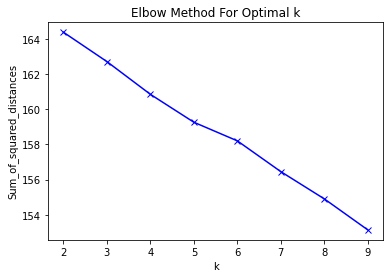

In [36]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, random_state=9)
    km = km.fit(features)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## 4.3 K-means clustering

In [37]:
true_k = 5

cls = KMeans(n_clusters=true_k, random_state=9)
cls.fit(features)

#cls.predict(features)
df["cluster"] = cls.labels_
print(df.sort_values(by=['cluster']))


    LABEL                                            MESSAGE  \
171  MYTH  The "breath test"   trying to hold your breath...   
201  MYTH  You can get the coronavirus if you eat at Chin...   
211  MYTH                        Everyone with COVID-19 dies   
213  MYTH      Face masks always protect against coronavirus   
214  MYTH  SARS-CoV-2 is just a mutated form of the commo...   
..    ...                                                ...   
101  MYTH               Other vaccines can prevent COVID-19.   
275  MYTH  Using steroids will prevent you from contracti...   
281  MYTH  Using mouthwash two times a day will prevent o...   
185  MYTH  Wearing gloves when you go out decreases the c...   
270  MYTH  Getting the flu shot will prevent you getting ...   

                                            clean_stop  cluster  
171  breath test try hold breath least 10 second de...        0  
201                          eat chinese restaurant us        0  
211                              

In [38]:
df[df["cluster"] == 3]

,LABEL,MESSAGE,clean_stop,cluster
131,MYTH,"If I have COVID-19, I’ll know it.",’ know,3
200,MYTH,"If you have coronavirus, ""you'll know""",know,3
218,MYTH,Coronavirus is the deadliest virus known to hu...,deadliest know human,3


## 4.4 Visualization

In [39]:
print("Top terms per cluster:")
order_centroids = cls.cluster_centers_.argsort()[:, ::-1]
terms = vec.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 nt
 vaccine
 flu
 pet
 chinese
 kill
 make
 children
 dangerous
 hand
Cluster 1:
 catch
 cause
 someone
 minute
 catch pet
 minute catch
 pet
 disease
 vitamin keep
 vitamin keep catch
Cluster 2:
 spread
 spread food
 food
 spread mosquito
 mosquito
 symptom
 cats dog
 blower
 leaf
 leaf blower
Cluster 3:
 know
 know human
 deadliest
 deadliest know
 deadliest know human
 human
 zip code
 face coveringmask keep
 eyes
 eyes darkness
Cluster 4:
 prevent
 wearing
 help prevent
 help
 vaccine prevent
 nose
 new
 infection
 using
 vaccine


Cluster: 0


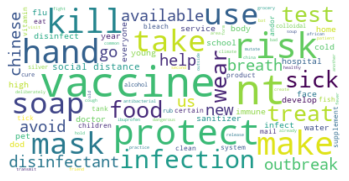

Cluster: 1


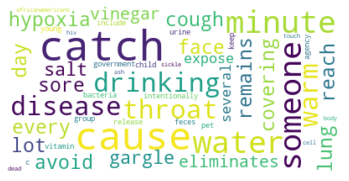

Cluster: 2


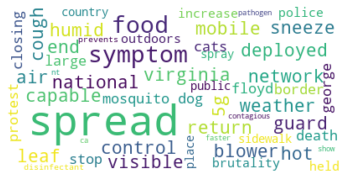

Cluster: 3


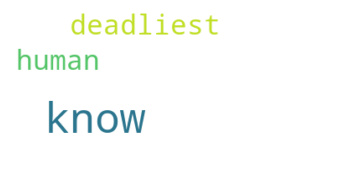

Cluster: 4


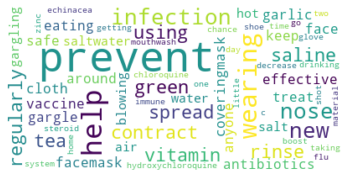

In [40]:
result=df[["LABEL", "clean_stop", "cluster"]]
for k in range(0,true_k):
    s=result[result.cluster==k]
    text=s['clean_stop'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# 5. Topic Modeling

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')

doc_term_matrix = count_vect.fit_transform(covid_data[covid_data['LABEL']=="MYTH"]['clean_stop'].values.astype('U'))

doc_term_matrix

<168x152 sparse matrix of type '<class 'numpy.int64'>'
	with 478 stored elements in Compressed Sparse Row format>

In [42]:
pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [43]:
from sklearn.decomposition import LatentDirichletAllocation
LDA_Advanced = LatentDirichletAllocation(n_components=4,        
                                  max_iter=10,               
                                  learning_method='online',   
                                  random_state=100,          
                                  batch_size=64,            
                                  evaluate_every = -1,       
                                  n_jobs = -1 )

LDA_Advanced.fit(doc_term_matrix)

LatentDirichletAllocation(batch_size=64, learning_method='online',
                          n_components=4, n_jobs=-1, random_state=100)

In [44]:
from __future__ import print_function

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [45]:
pyLDAvis.sklearn.prepare(LDA_Advanced, doc_term_matrix, count_vect)
#https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb#topic=3&lambda=1&term=

/Users/Zhuo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.049610 -0.161544       1        1  30.641798
2     -0.144283  0.076828       2        1  28.241505
0      0.049057  0.096047       3        1  22.826008
3      0.144836 -0.011331       4        1  18.290690, topic_info=         Term       Freq      Total Category  logprob  loglift
129    spread  13.000000  13.000000  Default  30.0000  30.0000
96         nt   9.000000   9.000000  Default  29.0000  29.0000
86       make   4.000000   4.000000  Default  28.0000  28.0000
143   vaccine   8.000000   8.000000  Default  27.0000  27.0000
108   protect   4.000000   4.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
89   military   1.273507   3.011241   Topic4  -4.2539   0.8382
9         bad   0.826215   2.039910   Topic4  -4.6865   0.7950
93       nato   1.244748   3.085821   Topic4  -4.2767   0.7909
143   vaccine   2.394928   8.838447   Topic4  -3.6223   0.3930
23    chinese   1.297079   4.300896   Topic4  -4.2355   0.5001

[176 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.363244       10
0         2  0.363244       10
1         4  0.806997  african
2         2  0.480723      air
3         3  0.919643  alcohol
...     ...       ...      ...
148       3  0.235804     wear
149       3  0.858363  wearing
150       4  0.742123     year
151       1  0.298431    young
151       2  0.596862    young

[180 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

In [46]:
#Use components_ to get the first topic at index 0
first_topic = LDA_Advanced.components_[0]
#Out of 14546 probabilities for each word for topic 1, sort the indexes according to probability values - argsort().
#Return last 10 indexes [-10]
top_topic_words = first_topic.argsort()[-10:]

for i in top_topic_words:
    print(count_vect.get_feature_names()[i])

soap
wearing
new
disinfectant
home
infection
body
prevent
treat
protect


/Users/Zhuo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [47]:
for i,topic in enumerate(LDA_Advanced.components_):
    print(f'Top 10 words for topic #{i+1}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

Top 10 words for topic #1:
['fight', 'human', 'decrease', 'know', 'help', 'soap', 'wearing', 'new', 'disinfectant', 'home', 'infection', 'body', 'prevent', 'treat', 'protect']


Top 10 words for topic #2:
['disinfect', 'place', 'contract', 'service', 'cause', 'wear', 'outbreak', 'flu', 'pet', 'vitamin', 'like', 'disease', 'mask', 'catch', 'spread']


Top 10 words for topic #3:
['using', 'drinking', 'distance', 'social', 'infect', 'develop', 'test', 'breath', 'cough', 'risk', 'avoid', 'water', 'vaccine', 'prevent', 'nt']


Top 10 words for topic #4:
['doctor', 'cold', 'grocery', 'outside', 'available', 'hand', 'use', 'vaccine', 'new', 'sick', 'school', 'kill', 'year', 'food', 'make']




/Users/Zhuo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

